<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sklearn Tuner for CNN Activity Classifier - V3

In this notebook, we use SKlearn  to tune a CNN neural net to classify PE activity.

#### Load dependencies

In [1]:
import os  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import AveragePooling1D, LeakyReLU , MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import sklearn
# bug in sklearn wrapper
#https://stackoverflow.com/questions/59746974/cannot-clone-object-tensorflow-python-keras-wrappers-scikit-learn-kerasclassifi
if sklearn.__version__ != '0.21.2':
    print("updating sklearn ...")
    !pip install --user scikit-learn==0.21.2
    


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9231755697673437919
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4783861506879629581
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4022219571
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18018878115323770423
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16828206419121335104
physical_device_desc: "device: XLA_GPU device"
]
# GPUs Available:  1


#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/tunecnn-sklearn-2'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency


In [3]:
# sklearn hyperparams
params = {
    'n_conv_1':[512, 768], # filters, a.k.a. kernels
    'k_conv_1':[2, 3], # kernel length
    'n_conv_2':[256, 512], # filters, a.k.a. kernels
    'k_conv_2':[2, 3], # kernel length
    'n_conv_3':[256, 512], # filters, a.k.a. kernels
    'k_conv_3':[2, 3], # kernel length
    'maxpooling_pool_size':[3, 5],
    'avepooling_pool_size':[3, 5],
    'n_dense_1':[256, 384, 512],
    'dropout_1':[0.2, 0.3],
    'n_dense_2':[256, 384, 512],
    'dropout_2':[0.2, 0.3],
    'activation_conv':['elu', 'relu', LeakyReLU()],
    'activation_dense':['elu', 'relu', LeakyReLU()]
}

# training:
n_tune_iter = 20
cv = 3
epochs = 60
batch_size = 256


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [4]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [5]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']
input_shape = list(accel_array.shape)


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [6]:
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)

In [7]:
y = to_categorical(labels_array_int, num_classes=n_class)


### Splitting and shuffeling the data

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)


#### Design neural network architecture

In [9]:
params

{'n_conv_1': [512, 768],
 'k_conv_1': [2, 3],
 'n_conv_2': [256, 512],
 'k_conv_2': [2, 3],
 'n_conv_3': [256, 512],
 'k_conv_3': [2, 3],
 'maxpooling_pool_size': [3, 5],
 'avepooling_pool_size': [3, 5],
 'n_dense_1': [256, 384, 512],
 'dropout_1': [0.2, 0.3],
 'n_dense_2': [256, 384, 512],
 'dropout_2': [0.2, 0.3],
 'activation_conv': ['elu',
  'relu',
 'activation_dense': ['elu',
  'relu',
  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU at 0x1d5b5607388>]}

In [10]:
def create_model(n_conv_1=256, k_conv_1=3, n_conv_2=256, k_conv_2=3, n_conv_3=256, k_conv_3=3,
                 maxpooling_pool_size = 2, avepooling_pool_size = 2, n_dense_1=256, dropout_1=0.2,
                 n_dense_2=256, dropout_2=0.2, activation_conv= 'relu', activation_dense= 'elu'
                ):
    model = Sequential()
    model.add(Conv1D(n_conv_1, k_conv_1, activation=activation_conv, input_shape=input_shape[1:]))
    model.add(MaxPool1D(pool_size = maxpooling_pool_size))
    model.add(Conv1D(n_conv_2, k_conv_2, activation=activation_conv))
    model.add(AveragePooling1D(pool_size = avepooling_pool_size))
    model.add(Conv1D(n_conv_3, k_conv_3, activation=activation_conv))
    # model.add(GlobalMaxPooling1D())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(n_dense_1, activation=activation_dense))
    model.add(Dropout(dropout_1))
    model.add(Dense(n_dense_2, activation=activation_dense))
    model.add(Dropout(dropout_2))
    model.add(Dense(n_class, activation='softmax'))
    model.summary()
    print(f"""n_conv_1 = {n_conv_1}, k_conv_1 = {k_conv_1},  n_conv_2 = {n_conv_2}, k_conv_2 = {k_conv_2}, 
          n_conv_3 = {n_conv_3},  k_conv_3 = {k_conv_3},  maxpooling_pool_size = {maxpooling_pool_size},
          avepooling_pool_size = {avepooling_pool_size},  n_dense_1 = {n_dense_1}, dropout_1 = {dropout_1},
          n_dense_2 = {n_dense_2}, dropout_2 = {dropout_2}, activation_conv=  {activation_conv},
          activation_dense=  {activation_dense}""")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [11]:
model_default = create_model()
model_default.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 256)           2560      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19, 256)           196864    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

In [12]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size)

In [13]:
%%time
rscv = RandomizedSearchCV(model, param_distributions=params, cv=cv, n_iter=n_tune_iter)
rscv_results = rscv.fit(X_train,y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 88, 512)           5120      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 512)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 28, 512)           524800    
_________________________________________________________________
average_pooling1d_1 (Average (None, 5, 512)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3, 512)            786944    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

152/152 [==============================] - 5s 30ms/step - loss: 0.0879 - accuracy: 0.9664 0s - loss: 0.0887 - accu
Epoch 56/60
152/152 [==============================] - 5s 30ms/step - loss: 0.0931 - accuracy: 0.9658
Epoch 57/60
152/152 [==============================] - 5s 30ms/step - loss: 0.0802 - accuracy: 0.9704
Epoch 58/60
152/152 [==============================] - 5s 30ms/step - loss: 0.0802 - accuracy: 0.9691
Epoch 59/60
152/152 [==============================] - 5s 30ms/step - loss: 0.0758 - accuracy: 0.9711
Epoch 60/60
76/76 [==============================] - 1s 12ms/step - loss: 0.3421 - accuracy: 0.9294
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 88, 512)           5120      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 29, 512)           0         
_________________________

152/152 [==============================] - 3s 23ms/step - loss: 0.2408 - accuracy: 0.9077
Epoch 51/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2503 - accuracy: 0.9025
Epoch 52/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2342 - accuracy: 0.9102
Epoch 53/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2443 - accuracy: 0.9063
Epoch 54/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2387 - accuracy: 0.9080
Epoch 55/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2341 - accuracy: 0.9106
Epoch 56/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2262 - accuracy: 0.9114
Epoch 57/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2353 - accuracy: 0.9103
Epoch 58/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2258 - accuracy: 0.9137
Epoch 59/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2314 - accuracy:

152/152 [==============================] - 3s 23ms/step - loss: 0.2394 - accuracy: 0.9094
Epoch 49/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2409 - accuracy: 0.9061
Epoch 50/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2438 - accuracy: 0.9049
Epoch 51/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2303 - accuracy: 0.9106
Epoch 52/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2399 - accuracy: 0.9082
Epoch 53/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2353 - accuracy: 0.9084
Epoch 54/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2295 - accuracy: 0.9101
Epoch 55/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2251 - accuracy: 0.9141
Epoch 56/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2287 - accuracy: 0.9128
Epoch 57/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2230 - accuracy:

Epoch 46/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2565 - accuracy: 0.9013
Epoch 47/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2505 - accuracy: 0.9037
Epoch 48/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2446 - accuracy: 0.9052
Epoch 49/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2553 - accuracy: 0.9022
Epoch 50/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2456 - accuracy: 0.9047
Epoch 51/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2393 - accuracy: 0.9066
Epoch 52/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2358 - accuracy: 0.9098
Epoch 53/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2431 - accuracy: 0.9059
Epoch 54/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2276 - accuracy: 0.9127
Epoch 55/60
152/152 [==============================] - 3s 23ms/step - loss: 0.2283

152/152 [==============================] - 5s 33ms/step - loss: 0.1572 - accuracy: 0.9415
Epoch 43/60
152/152 [==============================] - 5s 33ms/step - loss: 0.1508 - accuracy: 0.9438
Epoch 44/60
152/152 [==============================] - 5s 33ms/step - loss: 0.1487 - accuracy: 0.9447
Epoch 45/60
152/152 [==============================] - 5s 33ms/step - loss: 0.1443 - accuracy: 0.9457
Epoch 46/60
152/152 [==============================] - 5s 33ms/step - loss: 0.1400 - accuracy: 0.9463
Epoch 47/60
152/152 [==============================] - 5s 33ms/step - loss: 0.1462 - accuracy: 0.9443
Epoch 48/60
152/152 [==============================] - 5s 33ms/step - loss: 0.1323 - accuracy: 0.9496
Epoch 49/60
152/152 [==============================] - 5s 33ms/step - loss: 0.1373 - accuracy: 0.9476
Epoch 50/60
152/152 [==============================] - 5s 33ms/step - loss: 0.1421 - accuracy: 0.9474
Epoch 51/60
152/152 [==============================] - 5s 33ms/step - loss: 0.1353 - accuracy:

152/152 [==============================] - 4s 29ms/step - loss: 0.1153 - accuracy: 0.9572
Epoch 39/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1027 - accuracy: 0.9606
Epoch 40/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1145 - accuracy: 0.9570
Epoch 41/60
152/152 [==============================] - 4s 29ms/step - loss: 0.0986 - accuracy: 0.9626
Epoch 42/60
152/152 [==============================] - 4s 29ms/step - loss: 0.0981 - accuracy: 0.9624
Epoch 43/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1026 - accuracy: 0.9609
Epoch 44/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1004 - accuracy: 0.9639
Epoch 45/60
152/152 [==============================] - 4s 29ms/step - loss: 0.0998 - accuracy: 0.9627
Epoch 46/60
152/152 [==============================] - 4s 29ms/step - loss: 0.0919 - accuracy: 0.9661
Epoch 47/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1007 - accuracy:

152/152 [==============================] - 4s 29ms/step - loss: 0.1200 - accuracy: 0.9539
Epoch 37/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1188 - accuracy: 0.9547
Epoch 38/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1183 - accuracy: 0.9542
Epoch 39/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1232 - accuracy: 0.9528
Epoch 40/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1084 - accuracy: 0.9586
Epoch 41/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1043 - accuracy: 0.9593
Epoch 42/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1175 - accuracy: 0.9562
Epoch 43/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1150 - accuracy: 0.9563
Epoch 44/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1046 - accuracy: 0.9592
Epoch 45/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1041 - accuracy:

152/152 [==============================] - 4s 29ms/step - loss: 0.1390 - accuracy: 0.9462
Epoch 32/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1238 - accuracy: 0.9520
Epoch 33/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1371 - accuracy: 0.9492
Epoch 34/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1266 - accuracy: 0.9524
Epoch 35/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1194 - accuracy: 0.9542
Epoch 36/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1154 - accuracy: 0.9567
Epoch 37/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1137 - accuracy: 0.9558
Epoch 38/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1177 - accuracy: 0.9561
Epoch 39/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1144 - accuracy: 0.9570
Epoch 40/60
152/152 [==============================] - 4s 29ms/step - loss: 0.1089 - accuracy:

152/152 [==============================] - 4s 28ms/step - loss: 0.3457 - accuracy: 0.8678
Epoch 22/60
152/152 [==============================] - ETA: 0s - loss: 0.3572 - accuracy: 0.86 - 4s 28ms/step - loss: 0.3568 - accuracy: 0.8620
Epoch 23/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3388 - accuracy: 0.8684
Epoch 24/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3345 - accuracy: 0.8697
Epoch 25/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3226 - accuracy: 0.8758
Epoch 26/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3363 - accuracy: 0.8683
Epoch 27/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3356 - accuracy: 0.8702
Epoch 28/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3200 - accuracy: 0.8743
Epoch 29/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3174 - accuracy: 0.8766
Epoch 30/60
152/152 [==============================]

152/152 [==============================] - 5s 35ms/step - loss: 0.4327 - accuracy: 0.8294
Epoch 17/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4274 - accuracy: 0.8306
Epoch 18/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4130 - accuracy: 0.8367
Epoch 19/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4027 - accuracy: 0.8422
Epoch 20/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4041 - accuracy: 0.8419
Epoch 21/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3848 - accuracy: 0.8510
Epoch 22/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3862 - accuracy: 0.8495
Epoch 23/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3736 - accuracy: 0.8521
Epoch 24/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3549 - accuracy: 0.8619
Epoch 25/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3538 - accuracy:

152/152 [==============================] - 5s 35ms/step - loss: 0.4474 - accuracy: 0.8250
Epoch 15/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4332 - accuracy: 0.8292
Epoch 16/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4296 - accuracy: 0.8338
Epoch 17/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4158 - accuracy: 0.8363
Epoch 18/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4085 - accuracy: 0.8402
Epoch 19/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3943 - accuracy: 0.8462
Epoch 20/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3838 - accuracy: 0.8510
Epoch 21/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3862 - accuracy: 0.8486
Epoch 22/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3674 - accuracy: 0.8558
Epoch 23/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3686 - accuracy:

152/152 [==============================] - 5s 35ms/step - loss: 0.4793 - accuracy: 0.8070
Epoch 13/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4747 - accuracy: 0.8087
Epoch 14/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4626 - accuracy: 0.8148
Epoch 15/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4397 - accuracy: 0.8263
Epoch 16/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4423 - accuracy: 0.8239
Epoch 17/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4234 - accuracy: 0.8315
Epoch 18/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4128 - accuracy: 0.8383
Epoch 19/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4126 - accuracy: 0.8370
Epoch 20/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3992 - accuracy: 0.8437
Epoch 21/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3915 - accuracy:

152/152 [==============================] - 5s 33ms/step - loss: 0.5030 - accuracy: 0.8075
Epoch 11/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4945 - accuracy: 0.8085
Epoch 12/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4729 - accuracy: 0.8201
Epoch 13/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4508 - accuracy: 0.8294
Epoch 14/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4365 - accuracy: 0.8343
Epoch 15/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4357 - accuracy: 0.8318
Epoch 16/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4268 - accuracy: 0.8368
Epoch 17/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4115 - accuracy: 0.8433
Epoch 18/60
152/152 [==============================] - 5s 33ms/step - loss: 0.3994 - accuracy: 0.8469
Epoch 19/60
152/152 [==============================] - 5s 33ms/step - loss: 0.3959 - accuracy:

152/152 [==============================] - 5s 33ms/step - loss: 0.5602 - accuracy: 0.7823
Epoch 9/60
152/152 [==============================] - 5s 33ms/step - loss: 0.5303 - accuracy: 0.7954
Epoch 10/60
152/152 [==============================] - 5s 33ms/step - loss: 0.5092 - accuracy: 0.8034
Epoch 11/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4831 - accuracy: 0.8166
Epoch 12/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4782 - accuracy: 0.8200
Epoch 13/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4624 - accuracy: 0.8247
Epoch 14/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4306 - accuracy: 0.8368
Epoch 15/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4268 - accuracy: 0.8371
Epoch 16/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4280 - accuracy: 0.8347
Epoch 17/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4122 - accuracy: 

Epoch 6/60
152/152 [==============================] - 5s 34ms/step - loss: 0.6361 - accuracy: 0.7483
Epoch 7/60
152/152 [==============================] - 5s 33ms/step - loss: 0.6013 - accuracy: 0.7640
Epoch 8/60
152/152 [==============================] - 5s 33ms/step - loss: 0.5602 - accuracy: 0.7845
Epoch 9/60
152/152 [==============================] - 5s 33ms/step - loss: 0.5229 - accuracy: 0.7997
Epoch 10/60
152/152 [==============================] - 5s 33ms/step - loss: 0.5199 - accuracy: 0.7993
Epoch 11/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4787 - accuracy: 0.8186
Epoch 12/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4595 - accuracy: 0.8226
Epoch 13/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4525 - accuracy: 0.8271
Epoch 14/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4455 - accuracy: 0.8299
Epoch 15/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4356 - a

152/152 [==============================] - 4s 25ms/step - loss: 1.1119 - accuracy: 0.5178
Epoch 2/60
152/152 [==============================] - 3s 22ms/step - loss: 0.8769 - accuracy: 0.6202
Epoch 3/60
152/152 [==============================] - 3s 22ms/step - loss: 0.7767 - accuracy: 0.6648
Epoch 4/60
152/152 [==============================] - 3s 22ms/step - loss: 0.7396 - accuracy: 0.6878
Epoch 5/60
152/152 [==============================] - 3s 22ms/step - loss: 0.6732 - accuracy: 0.7238
Epoch 6/60
152/152 [==============================] - 3s 22ms/step - loss: 0.6254 - accuracy: 0.7492
Epoch 7/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5826 - accuracy: 0.7658
Epoch 8/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5561 - accuracy: 0.7794
Epoch 9/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5116 - accuracy: 0.8024
Epoch 10/60
152/152 [==============================] - 3s 22ms/step - loss: 0.4956 - accuracy: 0.8064


152/152 [==============================] - 3s 22ms/step - loss: 1.0954 - accuracy: 0.5305
Epoch 2/60
152/152 [==============================] - 3s 22ms/step - loss: 0.8794 - accuracy: 0.6219
Epoch 3/60
152/152 [==============================] - 3s 22ms/step - loss: 0.7830 - accuracy: 0.6656
Epoch 4/60
152/152 [==============================] - 3s 22ms/step - loss: 0.7055 - accuracy: 0.7034
Epoch 5/60
152/152 [==============================] - 3s 22ms/step - loss: 0.6565 - accuracy: 0.7309
Epoch 6/60
152/152 [==============================] - 3s 22ms/step - loss: 0.6188 - accuracy: 0.7524
Epoch 7/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5895 - accuracy: 0.7648
Epoch 8/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5471 - accuracy: 0.7842
Epoch 9/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5166 - accuracy: 0.7972
Epoch 10/60
152/152 [==============================] - 3s 22ms/step - loss: 0.4968 - accuracy: 0.8060


152/152 [==============================] - 3s 22ms/step - loss: 1.1067 - accuracy: 0.5262
Epoch 2/60
152/152 [==============================] - 3s 22ms/step - loss: 0.8715 - accuracy: 0.6218
Epoch 3/60
152/152 [==============================] - 3s 22ms/step - loss: 0.7774 - accuracy: 0.6709
Epoch 4/60
152/152 [==============================] - 3s 22ms/step - loss: 0.7085 - accuracy: 0.7062
Epoch 5/60
152/152 [==============================] - 3s 22ms/step - loss: 0.6635 - accuracy: 0.7262
Epoch 6/60
152/152 [==============================] - 3s 22ms/step - loss: 0.6052 - accuracy: 0.7569
Epoch 7/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5882 - accuracy: 0.7674
Epoch 8/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5500 - accuracy: 0.7846
Epoch 9/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5073 - accuracy: 0.8050
Epoch 10/60
152/152 [==============================] - 3s 22ms/step - loss: 0.4963 - accuracy: 0.8085


Epoch 1/60
152/152 [==============================] - 8s 51ms/step - loss: 1.0592 - accuracy: 0.5499
Epoch 2/60
152/152 [==============================] - 7s 48ms/step - loss: 0.6563 - accuracy: 0.7437
Epoch 3/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4818 - accuracy: 0.8192
Epoch 4/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3948 - accuracy: 0.8539
Epoch 5/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3639 - accuracy: 0.8649
Epoch 6/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3379 - accuracy: 0.8733
Epoch 7/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3267 - accuracy: 0.8784
Epoch 8/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2967 - accuracy: 0.8894
Epoch 9/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2924 - accuracy: 0.8920
Epoch 10/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2795 - accura

152/152 [==============================] - 7s 48ms/step - loss: 1.0419 - accuracy: 0.5581
Epoch 2/60
152/152 [==============================] - 7s 48ms/step - loss: 0.6471 - accuracy: 0.7479
Epoch 3/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4752 - accuracy: 0.8231
Epoch 4/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4011 - accuracy: 0.8498
Epoch 5/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3775 - accuracy: 0.8576
Epoch 6/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3299 - accuracy: 0.8759
Epoch 7/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3216 - accuracy: 0.8791
Epoch 8/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3040 - accuracy: 0.8835
Epoch 9/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2923 - accuracy: 0.8897
Epoch 10/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2779 - accuracy: 0.8943


Epoch 1/60
152/152 [==============================] - 7s 48ms/step - loss: 1.0433 - accuracy: 0.5642
Epoch 2/60
152/152 [==============================] - 7s 48ms/step - loss: 0.6574 - accuracy: 0.7403
Epoch 3/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4789 - accuracy: 0.8203
Epoch 4/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4031 - accuracy: 0.8473
Epoch 5/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3676 - accuracy: 0.8611
Epoch 6/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3444 - accuracy: 0.8716
Epoch 7/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3234 - accuracy: 0.8783
Epoch 8/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3107 - accuracy: 0.8824
Epoch 9/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2869 - accuracy: 0.8914
Epoch 10/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2780 - accura

Epoch 1/60
152/152 [==============================] - 5s 31ms/step - loss: 1.1595 - accuracy: 0.5094
Epoch 2/60
152/152 [==============================] - 5s 31ms/step - loss: 1.0367 - accuracy: 0.5586
Epoch 3/60
152/152 [==============================] - 5s 31ms/step - loss: 0.9624 - accuracy: 0.5914
Epoch 4/60
152/152 [==============================] - 5s 31ms/step - loss: 0.9077 - accuracy: 0.6165
Epoch 5/60
152/152 [==============================] - 5s 31ms/step - loss: 0.8533 - accuracy: 0.6463
Epoch 6/60
152/152 [==============================] - 5s 31ms/step - loss: 0.8087 - accuracy: 0.6641
Epoch 7/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7648 - accuracy: 0.6823
Epoch 8/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7389 - accuracy: 0.6933 0s - loss: 0.7424 
Epoch 9/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6962 - accuracy: 0.7165
Epoch 10/60
152/152 [==============================] - 5s 31ms/step - lo

152/152 [==============================] - 5s 31ms/step - loss: 1.1604 - accuracy: 0.5086
Epoch 2/60
152/152 [==============================] - 5s 31ms/step - loss: 1.0312 - accuracy: 0.5632
Epoch 3/60
152/152 [==============================] - 5s 31ms/step - loss: 0.9593 - accuracy: 0.5906
Epoch 4/60
152/152 [==============================] - 5s 31ms/step - loss: 0.9069 - accuracy: 0.6185
Epoch 5/60
152/152 [==============================] - 5s 31ms/step - loss: 0.8371 - accuracy: 0.6519
Epoch 6/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7961 - accuracy: 0.6663
Epoch 7/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7498 - accuracy: 0.6893
Epoch 8/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7084 - accuracy: 0.7067
Epoch 9/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6763 - accuracy: 0.7226
Epoch 10/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6662 - accuracy: 0.7280


Epoch 1/60
152/152 [==============================] - 5s 31ms/step - loss: 1.1641 - accuracy: 0.5124
Epoch 2/60
152/152 [==============================] - 5s 31ms/step - loss: 1.0323 - accuracy: 0.5637
Epoch 3/60
152/152 [==============================] - 5s 31ms/step - loss: 0.9671 - accuracy: 0.5897
Epoch 4/60
152/152 [==============================] - 5s 31ms/step - loss: 0.9145 - accuracy: 0.6118
Epoch 5/60
152/152 [==============================] - 5s 31ms/step - loss: 0.8725 - accuracy: 0.6358
Epoch 6/60
152/152 [==============================] - 5s 31ms/step - loss: 0.8147 - accuracy: 0.6598
Epoch 7/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7735 - accuracy: 0.6781
Epoch 8/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7390 - accuracy: 0.6938
Epoch 9/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7093 - accuracy: 0.7100
Epoch 10/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6691 - accura

Epoch 1/60
152/152 [==============================] - 5s 35ms/step - loss: 1.1583 - accuracy: 0.5167
Epoch 2/60
152/152 [==============================] - 5s 31ms/step - loss: 0.8919 - accuracy: 0.6441
Epoch 3/60
152/152 [==============================] - 5s 31ms/step - loss: 0.8224 - accuracy: 0.6711
Epoch 4/60
152/152 [==============================] - 5s 32ms/step - loss: 0.7791 - accuracy: 0.6894
Epoch 5/60
152/152 [==============================] - 5s 32ms/step - loss: 0.7553 - accuracy: 0.6983
Epoch 6/60
152/152 [==============================] - 5s 32ms/step - loss: 0.7089 - accuracy: 0.7177
Epoch 7/60
152/152 [==============================] - 5s 32ms/step - loss: 0.7040 - accuracy: 0.7193
Epoch 8/60
152/152 [==============================] - 5s 32ms/step - loss: 0.6702 - accuracy: 0.7310
Epoch 9/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6388 - accuracy: 0.7437
Epoch 10/60
152/152 [==============================] - 5s 32ms/step - loss: 0.6068 - accura

152/152 [==============================] - 5s 32ms/step - loss: 1.1481 - accuracy: 0.5227
Epoch 2/60
152/152 [==============================] - 5s 32ms/step - loss: 0.8775 - accuracy: 0.6503
Epoch 3/60
152/152 [==============================] - 5s 31ms/step - loss: 0.8201 - accuracy: 0.6745 0s - loss:
Epoch 4/60
152/152 [==============================] - 5s 32ms/step - loss: 0.7676 - accuracy: 0.6955
Epoch 5/60
152/152 [==============================] - 5s 32ms/step - loss: 0.7655 - accuracy: 0.6939
Epoch 6/60
152/152 [==============================] - 5s 32ms/step - loss: 0.7222 - accuracy: 0.7127
Epoch 7/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6991 - accuracy: 0.7209
Epoch 8/60
152/152 [==============================] - 5s 32ms/step - loss: 0.6688 - accuracy: 0.7308
Epoch 9/60
152/152 [==============================] - 5s 32ms/step - loss: 0.6538 - accuracy: 0.7357
Epoch 10/60
152/152 [==============================] - 5s 32ms/step - loss: 0.6138 - accura

Epoch 1/60
152/152 [==============================] - 5s 32ms/step - loss: 1.1684 - accuracy: 0.5115
Epoch 2/60
152/152 [==============================] - 5s 32ms/step - loss: 0.9048 - accuracy: 0.6355
Epoch 3/60
152/152 [==============================] - 5s 31ms/step - loss: 0.8150 - accuracy: 0.6748
Epoch 4/60
152/152 [==============================] - 5s 32ms/step - loss: 0.7987 - accuracy: 0.6849
Epoch 5/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7557 - accuracy: 0.7004
Epoch 6/60
152/152 [==============================] - 5s 32ms/step - loss: 0.7509 - accuracy: 0.6985
Epoch 7/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7260 - accuracy: 0.7100
Epoch 8/60
152/152 [==============================] - 5s 32ms/step - loss: 0.6888 - accuracy: 0.7246
Epoch 9/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6679 - accuracy: 0.7347
Epoch 10/60
152/152 [==============================] - 5s 32ms/step - loss: 0.6371 - accura

Epoch 1/60
152/152 [==============================] - 5s 31ms/step - loss: 1.0861 - accuracy: 0.5420
Epoch 2/60
152/152 [==============================] - 5s 31ms/step - loss: 0.8460 - accuracy: 0.6600 0s - loss: 0.8
Epoch 3/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7529 - accuracy: 0.6991
Epoch 4/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7114 - accuracy: 0.7184
Epoch 5/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6851 - accuracy: 0.7246
Epoch 6/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6477 - accuracy: 0.7398
Epoch 7/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6418 - accuracy: 0.7436
Epoch 8/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6101 - accuracy: 0.7537
Epoch 9/60
152/152 [==============================] - 5s 31ms/step - loss: 0.5908 - accuracy: 0.7638
Epoch 10/60
152/152 [==============================] - 5s 31ms/step - loss: 

Epoch 1/60
152/152 [==============================] - 5s 31ms/step - loss: 1.1063 - accuracy: 0.5353
Epoch 2/60
152/152 [==============================] - 5s 31ms/step - loss: 0.8476 - accuracy: 0.6591
Epoch 3/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7614 - accuracy: 0.6990
Epoch 4/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7143 - accuracy: 0.7156
Epoch 5/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6956 - accuracy: 0.7221
Epoch 6/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6695 - accuracy: 0.7322
Epoch 7/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6354 - accuracy: 0.7436
Epoch 8/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6079 - accuracy: 0.7571
Epoch 9/60
152/152 [==============================] - 5s 31ms/step - loss: 0.5761 - accuracy: 0.7673
Epoch 10/60
152/152 [==============================] - 5s 31ms/step - loss: 0.5748 - accura

Epoch 1/60
152/152 [==============================] - 5s 31ms/step - loss: 1.0952 - accuracy: 0.5401
Epoch 2/60
152/152 [==============================] - 5s 31ms/step - loss: 0.8427 - accuracy: 0.6608 0s - loss: 0.8478 
Epoch 3/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7667 - accuracy: 0.6947
Epoch 4/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7201 - accuracy: 0.7108
Epoch 5/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6872 - accuracy: 0.7277
Epoch 6/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6643 - accuracy: 0.7351
Epoch 7/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6288 - accuracy: 0.7501
Epoch 8/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6088 - accuracy: 0.7564
Epoch 9/60
152/152 [==============================] - 5s 31ms/step - loss: 0.5935 - accuracy: 0.7642
Epoch 10/60
152/152 [==============================] - 5s 31ms/step - lo

152/152 [==============================] - 3s 23ms/step - loss: 1.0384 - accuracy: 0.5591
Epoch 2/60
152/152 [==============================] - 3s 21ms/step - loss: 0.7388 - accuracy: 0.6922
Epoch 3/60
152/152 [==============================] - 3s 21ms/step - loss: 0.6013 - accuracy: 0.7545
Epoch 4/60
152/152 [==============================] - 3s 21ms/step - loss: 0.5156 - accuracy: 0.7958
Epoch 5/60
152/152 [==============================] - 3s 21ms/step - loss: 0.4438 - accuracy: 0.8321
Epoch 6/60
152/152 [==============================] - 3s 21ms/step - loss: 0.4050 - accuracy: 0.8481
Epoch 7/60
152/152 [==============================] - 3s 21ms/step - loss: 0.3783 - accuracy: 0.8603
Epoch 8/60
152/152 [==============================] - 3s 21ms/step - loss: 0.3476 - accuracy: 0.8714
Epoch 9/60
152/152 [==============================] - 3s 21ms/step - loss: 0.3178 - accuracy: 0.8833
Epoch 10/60
152/152 [==============================] - 3s 21ms/step - loss: 0.3060 - accuracy: 0.8872


152/152 [==============================] - 3s 21ms/step - loss: 1.0413 - accuracy: 0.5559
Epoch 2/60
152/152 [==============================] - 3s 21ms/step - loss: 0.7243 - accuracy: 0.6970 0s - loss: 0.7
Epoch 3/60
152/152 [==============================] - 3s 21ms/step - loss: 0.5834 - accuracy: 0.7631 0s - los
Epoch 4/60
152/152 [==============================] - 3s 21ms/step - loss: 0.5006 - accuracy: 0.8044
Epoch 5/60
152/152 [==============================] - 3s 21ms/step - loss: 0.4348 - accuracy: 0.8353
Epoch 6/60
152/152 [==============================] - 3s 21ms/step - loss: 0.3912 - accuracy: 0.8546
Epoch 7/60
152/152 [==============================] - 3s 21ms/step - loss: 0.3614 - accuracy: 0.8665
Epoch 8/60
152/152 [==============================] - 3s 21ms/step - loss: 0.3320 - accuracy: 0.8763
Epoch 9/60
152/152 [==============================] - 3s 21ms/step - loss: 0.3079 - accuracy: 0.8880
Epoch 10/60
152/152 [==============================] - 3s 21ms/step - loss: 0.

152/152 [==============================] - 3s 21ms/step - loss: 1.0501 - accuracy: 0.5547
Epoch 2/60
152/152 [==============================] - 3s 21ms/step - loss: 0.7201 - accuracy: 0.6933
Epoch 3/60
152/152 [==============================] - 3s 21ms/step - loss: 0.5880 - accuracy: 0.7617
Epoch 4/60
152/152 [==============================] - 3s 21ms/step - loss: 0.5029 - accuracy: 0.8046
Epoch 5/60
152/152 [==============================] - 3s 21ms/step - loss: 0.4443 - accuracy: 0.8302
Epoch 6/60
152/152 [==============================] - 3s 21ms/step - loss: 0.3883 - accuracy: 0.8552
Epoch 7/60
152/152 [==============================] - 3s 21ms/step - loss: 0.3620 - accuracy: 0.8654
Epoch 8/60
152/152 [==============================] - 3s 21ms/step - loss: 0.3478 - accuracy: 0.8697
Epoch 9/60
152/152 [==============================] - 3s 21ms/step - loss: 0.3275 - accuracy: 0.8789
Epoch 10/60
152/152 [==============================] - 3s 21ms/step - loss: 0.3040 - accuracy: 0.8871


152/152 [==============================] - 6s 38ms/step - loss: 1.0927 - accuracy: 0.5400
Epoch 2/60
152/152 [==============================] - 5s 36ms/step - loss: 0.7730 - accuracy: 0.6794
Epoch 3/60
152/152 [==============================] - 5s 36ms/step - loss: 0.5990 - accuracy: 0.7577
Epoch 4/60
152/152 [==============================] - 5s 36ms/step - loss: 0.4955 - accuracy: 0.8080
Epoch 5/60
152/152 [==============================] - 5s 36ms/step - loss: 0.4274 - accuracy: 0.8389
Epoch 6/60
152/152 [==============================] - 5s 36ms/step - loss: 0.3838 - accuracy: 0.8564
Epoch 7/60
152/152 [==============================] - 5s 36ms/step - loss: 0.3545 - accuracy: 0.8661
Epoch 8/60
152/152 [==============================] - 5s 36ms/step - loss: 0.3374 - accuracy: 0.8737
Epoch 9/60
152/152 [==============================] - 5s 36ms/step - loss: 0.3102 - accuracy: 0.8831
Epoch 10/60
152/152 [==============================] - 5s 36ms/step - loss: 0.2973 - accuracy: 0.8873


152/152 [==============================] - 5s 36ms/step - loss: 1.0911 - accuracy: 0.5403
Epoch 2/60
152/152 [==============================] - 5s 36ms/step - loss: 0.7526 - accuracy: 0.6931
Epoch 3/60
152/152 [==============================] - 5s 36ms/step - loss: 0.6011 - accuracy: 0.7586
Epoch 4/60
152/152 [==============================] - 5s 36ms/step - loss: 0.5115 - accuracy: 0.7997
Epoch 5/60
152/152 [==============================] - 5s 36ms/step - loss: 0.4323 - accuracy: 0.8330
Epoch 6/60
152/152 [==============================] - 5s 36ms/step - loss: 0.3861 - accuracy: 0.8547
Epoch 7/60
152/152 [==============================] - 5s 36ms/step - loss: 0.3604 - accuracy: 0.8642
Epoch 8/60
152/152 [==============================] - 5s 36ms/step - loss: 0.3431 - accuracy: 0.8702
Epoch 9/60
152/152 [==============================] - 5s 36ms/step - loss: 0.3203 - accuracy: 0.8796
Epoch 10/60
152/152 [==============================] - 5s 36ms/step - loss: 0.2969 - accuracy: 0.8896


152/152 [==============================] - 5s 36ms/step - loss: 1.0996 - accuracy: 0.5360
Epoch 2/60
152/152 [==============================] - 5s 36ms/step - loss: 0.7799 - accuracy: 0.6732
Epoch 3/60
152/152 [==============================] - 5s 36ms/step - loss: 0.6203 - accuracy: 0.7473
Epoch 4/60
152/152 [==============================] - 5s 36ms/step - loss: 0.5262 - accuracy: 0.7891
Epoch 5/60
152/152 [==============================] - 5s 36ms/step - loss: 0.4533 - accuracy: 0.8233
Epoch 6/60
152/152 [==============================] - 5s 36ms/step - loss: 0.3989 - accuracy: 0.8483
Epoch 7/60
152/152 [==============================] - 5s 36ms/step - loss: 0.3658 - accuracy: 0.8626
Epoch 8/60
152/152 [==============================] - 5s 36ms/step - loss: 0.3328 - accuracy: 0.8735
Epoch 9/60
152/152 [==============================] - 5s 36ms/step - loss: 0.3134 - accuracy: 0.8821
Epoch 10/60
152/152 [==============================] - 5s 36ms/step - loss: 0.3008 - accuracy: 0.8861


Epoch 1/60
152/152 [==============================] - 6s 38ms/step - loss: 1.1249 - accuracy: 0.5194
Epoch 2/60
152/152 [==============================] - 5s 34ms/step - loss: 0.9137 - accuracy: 0.6144
Epoch 3/60
152/152 [==============================] - 5s 34ms/step - loss: 0.7958 - accuracy: 0.6608
Epoch 4/60
152/152 [==============================] - 5s 34ms/step - loss: 0.7228 - accuracy: 0.6982
Epoch 5/60
152/152 [==============================] - 5s 34ms/step - loss: 0.6485 - accuracy: 0.7389
Epoch 6/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5965 - accuracy: 0.7618
Epoch 7/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5576 - accuracy: 0.7792
Epoch 8/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5237 - accuracy: 0.7945
Epoch 9/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4839 - accuracy: 0.8125
Epoch 10/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4770 - accura

152/152 [==============================] - 5s 34ms/step - loss: 1.1212 - accuracy: 0.5206
Epoch 2/60
152/152 [==============================] - 5s 34ms/step - loss: 0.9080 - accuracy: 0.6135
Epoch 3/60
152/152 [==============================] - 5s 34ms/step - loss: 0.7919 - accuracy: 0.6612
Epoch 4/60
152/152 [==============================] - 5s 34ms/step - loss: 0.7101 - accuracy: 0.7043
Epoch 5/60
152/152 [==============================] - 5s 34ms/step - loss: 0.6380 - accuracy: 0.7431
Epoch 6/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5806 - accuracy: 0.7674
Epoch 7/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5533 - accuracy: 0.7844
Epoch 8/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5142 - accuracy: 0.7981
Epoch 9/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4872 - accuracy: 0.8106
Epoch 10/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4701 - accuracy: 0.8176


Epoch 1/60
152/152 [==============================] - 5s 34ms/step - loss: 1.1084 - accuracy: 0.5315
Epoch 2/60
152/152 [==============================] - 5s 34ms/step - loss: 0.8910 - accuracy: 0.6257
Epoch 3/60
152/152 [==============================] - 5s 34ms/step - loss: 0.7988 - accuracy: 0.6614
Epoch 4/60
152/152 [==============================] - 5s 34ms/step - loss: 0.7244 - accuracy: 0.6979
Epoch 5/60
152/152 [==============================] - 5s 34ms/step - loss: 0.6704 - accuracy: 0.7268
Epoch 6/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5958 - accuracy: 0.7608
Epoch 7/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5642 - accuracy: 0.7748
Epoch 8/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5344 - accuracy: 0.7886
Epoch 9/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4975 - accuracy: 0.8053
Epoch 10/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4955 - accura

152/152 [==============================] - 5s 32ms/step - loss: 1.1802 - accuracy: 0.5002
Epoch 2/60
152/152 [==============================] - 5s 30ms/step - loss: 1.0398 - accuracy: 0.5571
Epoch 3/60
152/152 [==============================] - 5s 30ms/step - loss: 0.9884 - accuracy: 0.5828
Epoch 4/60
152/152 [==============================] - 5s 30ms/step - loss: 0.9423 - accuracy: 0.6008 0s - loss: 0.9423 - accuracy: 0.60
Epoch 5/60
152/152 [==============================] - 4s 30ms/step - loss: 0.9045 - accuracy: 0.6180
Epoch 6/60
152/152 [==============================] - 5s 30ms/step - loss: 0.8579 - accuracy: 0.6368
Epoch 7/60
152/152 [==============================] - 5s 30ms/step - loss: 0.7969 - accuracy: 0.6665
Epoch 8/60
152/152 [==============================] - 5s 30ms/step - loss: 0.7424 - accuracy: 0.6907
Epoch 9/60
152/152 [==============================] - 5s 30ms/step - loss: 0.7049 - accuracy: 0.7057
Epoch 10/60
152/152 [==============================] - 5s 30ms/step

152/152 [==============================] - 5s 30ms/step - loss: 1.1752 - accuracy: 0.5010
Epoch 2/60
152/152 [==============================] - 4s 30ms/step - loss: 1.0353 - accuracy: 0.5615
Epoch 3/60
152/152 [==============================] - 5s 30ms/step - loss: 0.9816 - accuracy: 0.5884
Epoch 4/60
152/152 [==============================] - 5s 30ms/step - loss: 0.9492 - accuracy: 0.6018
Epoch 5/60
152/152 [==============================] - 4s 30ms/step - loss: 0.9120 - accuracy: 0.6183
Epoch 6/60
152/152 [==============================] - 5s 30ms/step - loss: 0.8702 - accuracy: 0.6357
Epoch 7/60
152/152 [==============================] - 5s 30ms/step - loss: 0.8183 - accuracy: 0.6577
Epoch 8/60
152/152 [==============================] - 5s 30ms/step - loss: 0.7688 - accuracy: 0.6789
Epoch 9/60
152/152 [==============================] - 5s 30ms/step - loss: 0.7123 - accuracy: 0.7012
Epoch 10/60
152/152 [==============================] - 5s 30ms/step - loss: 0.6724 - accuracy: 0.7208


Epoch 1/60
152/152 [==============================] - 5s 30ms/step - loss: 1.1758 - accuracy: 0.4994
Epoch 2/60
152/152 [==============================] - 4s 30ms/step - loss: 1.0381 - accuracy: 0.5577
Epoch 3/60
152/152 [==============================] - 5s 30ms/step - loss: 0.9889 - accuracy: 0.5807
Epoch 4/60
152/152 [==============================] - 5s 30ms/step - loss: 0.9514 - accuracy: 0.6005
Epoch 5/60
152/152 [==============================] - 5s 30ms/step - loss: 0.9146 - accuracy: 0.6194
Epoch 6/60
152/152 [==============================] - 5s 30ms/step - loss: 0.8716 - accuracy: 0.6334
Epoch 7/60
152/152 [==============================] - 5s 30ms/step - loss: 0.8106 - accuracy: 0.6583
Epoch 8/60
152/152 [==============================] - 5s 30ms/step - loss: 0.7606 - accuracy: 0.6816
Epoch 9/60
152/152 [==============================] - 5s 30ms/step - loss: 0.7182 - accuracy: 0.7011
Epoch 10/60
152/152 [==============================] - 5s 30ms/step - loss: 0.6794 - accura

152/152 [==============================] - 6s 40ms/step - loss: 0.9866 - accuracy: 0.5823
Epoch 2/60
152/152 [==============================] - 6s 38ms/step - loss: 0.6079 - accuracy: 0.7644
Epoch 3/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4735 - accuracy: 0.8227
Epoch 4/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4064 - accuracy: 0.8483
Epoch 5/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3582 - accuracy: 0.8646
Epoch 6/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3322 - accuracy: 0.8749
Epoch 7/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3224 - accuracy: 0.8805
Epoch 8/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2985 - accuracy: 0.8866
Epoch 9/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2943 - accuracy: 0.8897
Epoch 10/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2734 - accuracy: 0.8980


Epoch 1/60
152/152 [==============================] - 6s 38ms/step - loss: 1.0074 - accuracy: 0.5754
Epoch 2/60
152/152 [==============================] - 6s 38ms/step - loss: 0.6094 - accuracy: 0.7692
Epoch 3/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4531 - accuracy: 0.8317
Epoch 4/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3972 - accuracy: 0.8519
Epoch 5/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3554 - accuracy: 0.8677
Epoch 6/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3365 - accuracy: 0.8731
Epoch 7/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3136 - accuracy: 0.8807
Epoch 8/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3019 - accuracy: 0.8856
Epoch 9/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2800 - accuracy: 0.8938
Epoch 10/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2600 - accura

Epoch 1/60
152/152 [==============================] - 6s 38ms/step - loss: 1.0222 - accuracy: 0.5660
Epoch 2/60
152/152 [==============================] - 6s 38ms/step - loss: 0.6155 - accuracy: 0.7588
Epoch 3/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4695 - accuracy: 0.8248
Epoch 4/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4055 - accuracy: 0.8498
Epoch 5/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3538 - accuracy: 0.8677
Epoch 6/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3382 - accuracy: 0.8741
Epoch 7/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3225 - accuracy: 0.8788
Epoch 8/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3034 - accuracy: 0.8864
Epoch 9/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2832 - accuracy: 0.8951
Epoch 10/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2821 - accura

Epoch 1/60
152/152 [==============================] - 5s 34ms/step - loss: 1.1175 - accuracy: 0.5258
Epoch 2/60
152/152 [==============================] - 5s 34ms/step - loss: 0.8493 - accuracy: 0.6418
Epoch 3/60
152/152 [==============================] - 5s 34ms/step - loss: 0.6822 - accuracy: 0.7250
Epoch 4/60
152/152 [==============================] - 5s 34ms/step - loss: 0.6103 - accuracy: 0.7564
Epoch 5/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5496 - accuracy: 0.7847
Epoch 6/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4966 - accuracy: 0.8085
Epoch 7/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4733 - accuracy: 0.8161
Epoch 8/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4476 - accuracy: 0.8255
Epoch 9/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4377 - accuracy: 0.8309
Epoch 10/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4352 - accura

152/152 [==============================] - 5s 34ms/step - loss: 1.1068 - accuracy: 0.5309
Epoch 2/60
152/152 [==============================] - 5s 34ms/step - loss: 0.8254 - accuracy: 0.6554
Epoch 3/60
152/152 [==============================] - 5s 34ms/step - loss: 0.6749 - accuracy: 0.7273
Epoch 4/60
152/152 [==============================] - 5s 34ms/step - loss: 0.6055 - accuracy: 0.7603
Epoch 5/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5522 - accuracy: 0.7813
Epoch 6/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5210 - accuracy: 0.7968
Epoch 7/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4766 - accuracy: 0.8158
Epoch 8/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4579 - accuracy: 0.8224
Epoch 9/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4229 - accuracy: 0.8357
Epoch 10/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4346 - accuracy: 0.8320


Epoch 1/60
152/152 [==============================] - 5s 34ms/step - loss: 1.1104 - accuracy: 0.5296
Epoch 2/60
152/152 [==============================] - 5s 34ms/step - loss: 0.8529 - accuracy: 0.6393
Epoch 3/60
152/152 [==============================] - 5s 34ms/step - loss: 0.7020 - accuracy: 0.7165
Epoch 4/60
152/152 [==============================] - 5s 34ms/step - loss: 0.6157 - accuracy: 0.7566
Epoch 5/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5612 - accuracy: 0.7802
Epoch 6/60
152/152 [==============================] - 5s 34ms/step - loss: 0.5218 - accuracy: 0.7963
Epoch 7/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4909 - accuracy: 0.8099
Epoch 8/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4531 - accuracy: 0.8278
Epoch 9/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4477 - accuracy: 0.8253
Epoch 10/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4184 - accura

152/152 [==============================] - 3s 22ms/step - loss: 1.1146 - accuracy: 0.5272
Epoch 2/60
152/152 [==============================] - 3s 22ms/step - loss: 0.8950 - accuracy: 0.6177
Epoch 3/60
152/152 [==============================] - 3s 22ms/step - loss: 0.7999 - accuracy: 0.6561
Epoch 4/60
152/152 [==============================] - 3s 22ms/step - loss: 0.7505 - accuracy: 0.6811
Epoch 5/60
152/152 [==============================] - 3s 22ms/step - loss: 0.6838 - accuracy: 0.7165
Epoch 6/60
152/152 [==============================] - 3s 22ms/step - loss: 0.6121 - accuracy: 0.7531
Epoch 7/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5806 - accuracy: 0.7708
Epoch 8/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5504 - accuracy: 0.7839
Epoch 9/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5212 - accuracy: 0.7961
Epoch 10/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5009 - accuracy: 0.8035


Epoch 1/60
152/152 [==============================] - 3s 22ms/step - loss: 1.1078 - accuracy: 0.5296
Epoch 2/60
152/152 [==============================] - 3s 22ms/step - loss: 0.9126 - accuracy: 0.6141
Epoch 3/60
152/152 [==============================] - 3s 22ms/step - loss: 0.8082 - accuracy: 0.6527
Epoch 4/60
152/152 [==============================] - 3s 22ms/step - loss: 0.7471 - accuracy: 0.6792
Epoch 5/60
152/152 [==============================] - 3s 22ms/step - loss: 0.6925 - accuracy: 0.7072
Epoch 6/60
152/152 [==============================] - 3s 22ms/step - loss: 0.6363 - accuracy: 0.7345
Epoch 7/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5882 - accuracy: 0.7616
Epoch 8/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5425 - accuracy: 0.7847
Epoch 9/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5254 - accuracy: 0.7931
Epoch 10/60
152/152 [==============================] - 3s 22ms/step - loss: 0.4891 - accura

Epoch 1/60
152/152 [==============================] - 3s 22ms/step - loss: 1.1032 - accuracy: 0.5321
Epoch 2/60
152/152 [==============================] - 3s 22ms/step - loss: 0.9070 - accuracy: 0.6217
Epoch 3/60
152/152 [==============================] - 3s 22ms/step - loss: 0.8108 - accuracy: 0.6541
Epoch 4/60
152/152 [==============================] - 3s 22ms/step - loss: 0.7310 - accuracy: 0.6900
Epoch 5/60
152/152 [==============================] - 3s 22ms/step - loss: 0.6836 - accuracy: 0.7163
Epoch 6/60
152/152 [==============================] - 3s 22ms/step - loss: 0.6260 - accuracy: 0.7465
Epoch 7/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5855 - accuracy: 0.7642
Epoch 8/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5573 - accuracy: 0.7764
Epoch 9/60
152/152 [==============================] - 3s 22ms/step - loss: 0.5205 - accuracy: 0.7934
Epoch 10/60
152/152 [==============================] - 3s 22ms/step - loss: 0.4983 - accura

Epoch 1/60
152/152 [==============================] - 8s 53ms/step - loss: 1.1078 - accuracy: 0.5294
Epoch 2/60
152/152 [==============================] - 8s 52ms/step - loss: 0.7805 - accuracy: 0.6828
Epoch 3/60
152/152 [==============================] - 8s 53ms/step - loss: 0.6430 - accuracy: 0.7435
Epoch 4/60
152/152 [==============================] - 8s 52ms/step - loss: 0.5616 - accuracy: 0.7743
Epoch 5/60
152/152 [==============================] - 8s 52ms/step - loss: 0.5209 - accuracy: 0.7916
Epoch 6/60
152/152 [==============================] - 8s 52ms/step - loss: 0.4858 - accuracy: 0.8088
Epoch 7/60
152/152 [==============================] - 8s 52ms/step - loss: 0.4719 - accuracy: 0.8153
Epoch 8/60
152/152 [==============================] - 8s 52ms/step - loss: 0.4426 - accuracy: 0.8269
Epoch 9/60
152/152 [==============================] - 8s 52ms/step - loss: 0.4276 - accuracy: 0.8330
Epoch 10/60
152/152 [==============================] - 8s 52ms/step - loss: 0.4180 - accura

152/152 [==============================] - 8s 52ms/step - loss: 1.1113 - accuracy: 0.5316
Epoch 2/60
152/152 [==============================] - 8s 52ms/step - loss: 0.7799 - accuracy: 0.6790
Epoch 3/60
152/152 [==============================] - 8s 52ms/step - loss: 0.6612 - accuracy: 0.7317
Epoch 4/60
152/152 [==============================] - 8s 52ms/step - loss: 0.5575 - accuracy: 0.7797
Epoch 5/60
152/152 [==============================] - 8s 52ms/step - loss: 0.5225 - accuracy: 0.7949
Epoch 6/60
152/152 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.80 - 8s 52ms/step - loss: 0.4978 - accuracy: 0.8070
Epoch 7/60
152/152 [==============================] - 8s 52ms/step - loss: 0.4633 - accuracy: 0.8190
Epoch 8/60
152/152 [==============================] - 8s 52ms/step - loss: 0.4487 - accuracy: 0.8268
Epoch 9/60
152/152 [==============================] - 8s 52ms/step - loss: 0.4421 - accuracy: 0.8280
Epoch 10/60
152/152 [==============================] - 8s 52

Epoch 1/60
152/152 [==============================] - 8s 52ms/step - loss: 1.0759 - accuracy: 0.5437
Epoch 2/60
152/152 [==============================] - 8s 52ms/step - loss: 0.7525 - accuracy: 0.6977
Epoch 3/60
152/152 [==============================] - 8s 53ms/step - loss: 0.6508 - accuracy: 0.7398
Epoch 4/60
152/152 [==============================] - 8s 52ms/step - loss: 0.5619 - accuracy: 0.7764
Epoch 5/60
152/152 [==============================] - 8s 53ms/step - loss: 0.5238 - accuracy: 0.7948
Epoch 6/60
152/152 [==============================] - 8s 52ms/step - loss: 0.4895 - accuracy: 0.8085
Epoch 7/60
152/152 [==============================] - 8s 52ms/step - loss: 0.4803 - accuracy: 0.8133
Epoch 8/60
152/152 [==============================] - 8s 53ms/step - loss: 0.4424 - accuracy: 0.8268
Epoch 9/60
152/152 [==============================] - 8s 52ms/step - loss: 0.4253 - accuracy: 0.8331
Epoch 10/60
152/152 [==============================] - 8s 53ms/step - loss: 0.4279 - accura

228/228 [==============================] - 11s 49ms/step - loss: 0.9526 - accuracy: 0.6062
Epoch 2/60
228/228 [==============================] - 11s 48ms/step - loss: 0.5260 - accuracy: 0.7995
Epoch 3/60
228/228 [==============================] - 11s 48ms/step - loss: 0.4002 - accuracy: 0.8491
Epoch 4/60
228/228 [==============================] - 11s 48ms/step - loss: 0.3470 - accuracy: 0.8699
Epoch 5/60
228/228 [==============================] - 11s 48ms/step - loss: 0.3199 - accuracy: 0.8796
Epoch 6/60
228/228 [==============================] - 11s 48ms/step - loss: 0.2964 - accuracy: 0.8860
Epoch 7/60
228/228 [==============================] - 11s 48ms/step - loss: 0.2766 - accuracy: 0.8955
Epoch 8/60
228/228 [==============================] - 11s 48ms/step - loss: 0.2770 - accuracy: 0.8964
Epoch 9/60
228/228 [==============================] - 11s 48ms/step - loss: 0.2504 - accuracy: 0.9055
Epoch 10/60
228/228 [==============================] - 11s 48ms/step - loss: 0.2465 - accurac

In [14]:
!

In [15]:
print('Best score is: {} using {}'.format(rscv_results.best_score_,
rscv_results.best_params_))

Best score is: 0.9373348355293274 using {'n_dense_2': 256, 'n_dense_1': 512, 'n_conv_3': 256, 'n_conv_2': 512, 'n_conv_1': 768, 'maxpooling_pool_size': 3, 'k_conv_3': 3, 'k_conv_2': 3, 'k_conv_1': 3, 'dropout_2': 0.3, 'dropout_1': 0.3, 'avepooling_pool_size': 3, 'activation_dense': <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x000001D5B5607388>, 'activation_conv': 'relu'}


In [16]:
best_model = rscv_results.best_estimator_
best_param = rscv_results.best_params_

### Test the best model based on the validation data

In [17]:
y_hat = best_model.predict(X_valid)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [18]:
y_hat = to_categorical(y_hat)
y_hat[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

In [19]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

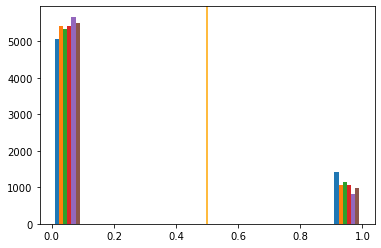

In [20]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [21]:
from sklearn.metrics import  accuracy_score as score
y_pred_classes = y_hat.round()
print(y_valid[0], y_hat[0], y_pred_classes[0])
acc = score(y_valid, y_pred_classes) * 100
acc

[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]


94.96602841260037

In [22]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [23]:
"{:0.2f}".format(pct_auc)

'96.98'

In [24]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [25]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [26]:
ydf.head(10)

,y_hat,y
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


In [27]:
results_df = pd.DataFrame(rscv_results.cv_results_['params'])
results_df['mean'] = rscv_results.cv_results_['mean_test_score']
results_df['std'] = rscv_results.cv_results_['std_test_score']
results_df.sort_values('mean', ascending=False, ignore_index=False)

,n_dense_2,n_dense_1,n_conv_3,n_conv_2,n_conv_1,maxpooling_pool_size,k_conv_3,k_conv_2,k_conv_1,dropout_2,dropout_1,avepooling_pool_size,activation_dense,activation_conv,mean,std
8,256,512,256,512,768,3,3,3,3,0.3,0.3,3,<tensorflow.python.keras.layers.advanced_activ...,relu,0.937335,0.002975
16,256,512,256,512,768,5,3,3,3,0.2,0.3,3,elu,relu,0.935447,0.001562
12,384,384,512,256,512,5,2,2,2,0.3,0.3,3,elu,relu,0.935224,0.002426
0,512,256,512,512,512,3,3,2,3,0.2,0.2,5,<tensorflow.python.keras.layers.advanced_activ...,relu,0.935070,0.004143
3,512,256,512,512,512,5,3,3,2,0.2,0.3,3,<tensorflow.python.keras.layers.advanced_activ...,relu,0.932668,0.001910
2,384,256,256,256,768,3,3,2,2,0.3,0.3,3,relu,relu,0.930265,0.002295
13,256,256,512,256,768,3,2,3,2,0.3,0.3,5,<tensorflow.python.keras.layers.advanced_activ...,relu,0.928944,0.002297
1,384,384,256,256,512,3,3,2,3,0.2,0.2,5,relu,<tensorflow.python.keras.layers.advanced_activ...,0.907787,0.008216
15,384,512,256,256,768,5,3,2,2,0.3,0.2,3,elu,elu,0.905968,0.003381
17,256,256,512,256,768,3,2,2,3,0.2,0.2,3,relu,<tensorflow.python.keras.layers.advanced_activ...,0.903720,0.000830


## Creating best model from the best param and train it for 60 epochs

In [57]:
n_dense_2= 256
n_dense_1= 512
n_conv_3= 256
n_conv_2= 512
n_conv_1= 768
maxpooling_pool_size= 2
k_conv_3= 3
k_conv_2= 3
k_conv_1= 3
dropout_2= 0.3
dropout_1= 0.25
avepooling_pool_size= 2
activation_dense = LeakyReLU()
activation_conv = 'relu'
model = Sequential()
model.add(Conv1D(n_conv_1, k_conv_1, activation=activation_conv, input_shape=input_shape[1:]))
model.add(MaxPool1D(pool_size = maxpooling_pool_size))
model.add(Conv1D(n_conv_2, k_conv_2, activation=activation_conv))
model.add(AveragePooling1D(pool_size = avepooling_pool_size))
model.add(Conv1D(n_conv_3, k_conv_3, activation=activation_conv))
# model.add(GlobalMaxPooling1D())
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense_1, activation=activation_dense))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation=activation_dense))
model.add(Dropout(dropout_2))
model.add(Dense(n_class, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [58]:
output_dir= 'model_ouput/tune-sklearn-2'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [59]:
epochs = 120
model.fit(X_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(X_valid, y_valid), 
         callbacks=[modelcheckpoint])

Epoch 1/120
228/228 [==============================] - 16s 71ms/step - loss: 0.9513 - accuracy: 0.6021 - val_loss: 0.6159 - val_accuracy: 0.7543
Epoch 2/120
228/228 [==============================] - 16s 69ms/step - loss: 0.5042 - accuracy: 0.8076 - val_loss: 0.3957 - val_accuracy: 0.8524
Epoch 3/120
228/228 [==============================] - 16s 69ms/step - loss: 0.3865 - accuracy: 0.8542 - val_loss: 0.3783 - val_accuracy: 0.8618
Epoch 4/120
228/228 [==============================] - 16s 69ms/step - loss: 0.3469 - accuracy: 0.8701 - val_loss: 0.3243 - val_accuracy: 0.8796
Epoch 5/120
228/228 [==============================] - 16s 69ms/step - loss: 0.3160 - accuracy: 0.8803 - val_loss: 0.3090 - val_accuracy: 0.8789
Epoch 6/120
228/228 [==============================] - 16s 69ms/step - loss: 0.2946 - accuracy: 0.8896 - val_loss: 0.2957 - val_accuracy: 0.8851
Epoch 7/120
228/228 [==============================] - 16s 69ms/step - loss: 0.2789 - accuracy: 0.8966 - val_loss: 0.2774 - val_ac

228/228 [==============================] - 16s 69ms/step - loss: 0.0591 - accuracy: 0.9789 - val_loss: 0.1911 - val_accuracy: 0.9591
Epoch 112/120
228/228 [==============================] - 16s 68ms/step - loss: 0.0516 - accuracy: 0.9807 - val_loss: 0.1887 - val_accuracy: 0.9616
Epoch 113/120
228/228 [==============================] - 16s 68ms/step - loss: 0.0736 - accuracy: 0.9752 - val_loss: 0.1666 - val_accuracy: 0.9608
Epoch 114/120
228/228 [==============================] - 16s 68ms/step - loss: 0.0500 - accuracy: 0.9814 - val_loss: 0.1874 - val_accuracy: 0.9588
Epoch 115/120
228/228 [==============================] - 16s 68ms/step - loss: 0.0480 - accuracy: 0.9819 - val_loss: 0.1879 - val_accuracy: 0.9614
Epoch 116/120
228/228 [==============================] - 16s 68ms/step - loss: 0.0480 - accuracy: 0.9820 - val_loss: 0.1901 - val_accuracy: 0.9642
Epoch 117/120
228/228 [==============================] - 16s 68ms/step - loss: 0.0515 - accuracy: 0.9806 - val_loss: 0.2009 - val_ac

In [61]:
model.load_weights(output_dir+"/weights.116.hdf5") 

In [62]:
y_hat = model.predict(X_valid)

In [63]:
len(y_hat)

6476

In [64]:
y_hat[0]

array([6.8225738e-05, 1.9944432e-07, 2.4306075e-08, 8.1681016e-08,
       1.1624115e-05, 9.9991977e-01], dtype=float32)

In [65]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

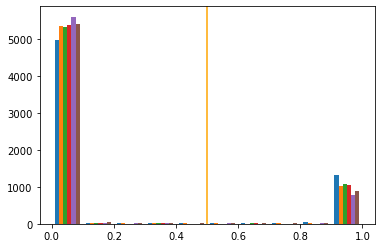

In [66]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [67]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'99.75'

In [68]:
y_pred_classes = y_hat.round()
acc = score(y_valid, y_pred_classes) * 100
"{:0.2f}".format(acc)

'96.32'

In [69]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [70]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [71]:
ydf.head(10)

,y_hat,y
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
